## Let's demo RivGraph on a mouse brain!
This demo walks through some steps for using RivGraph on non-river masks. This particular example is a scan of a mouse brain provided by the authors of [this paper](https://rdcu.be/ccn0Y). However, any binary mask can be transformed into its graphical representation with RivGraph.

The main difference in our approach here is that we can no longer use the convenient `delta` or `river` classes to manage our processing. Instead of applying the methods of those classes, we will directly call the functions we need. This demo will cover the following:

1. Making a mask from a grayscale image
2. Tidying up the mask using RivGraph tools
3. Computing a graphical representation of the mask
4. Plotting the graph
5. Pruning the graph based on link and node attributes

Some ideas for exporting results will be shown along the way. RivGraph was designed primarily for georeferenced masks, and thus al its export functionality requires some kind of georeferencing information. However, there are other options available for storing analysis results.

### 1. Making a mask from a grayscale image

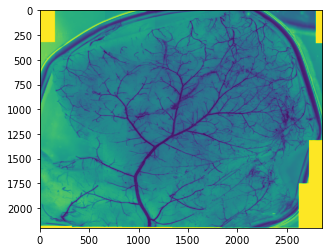

In [26]:
from skimage import io
from matplotlib import pyplot as plt

path_brain = "./data/Mouse_Brain/brain_scan.png"

# Read the grayscale image of a brain scan
I = io.imread(path_brain, as_gray=True)

# Look at it
plt.imshow(I)

Pretty cool. This is a 2-D scan of a 3-D mouse brain. What we're seeing in dark blue is the network of blood vessels that we'd like to represent graphically. Note that the ends of most of the blood vessels aren't acutally *ending*, but rather *diving* further into (or out of) the plane of the image.

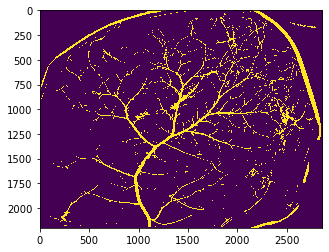

In [7]:
# The first thing we need to do is to binarize the image. 
# To do this, we can play around with a threshold value of the grayscale image.
# After some trials, it looks like pixel values less than 60 captures the blood vessels fairly well.
Ib = I<60

# Note that we set the interpolation to 'none' (not None).
plt.imshow(Ib, interpolation='none')

We now have a binary image of the brain's vascular network. But it also contains some features that we're not interested in, like the circumference of the brain. Remember that we want our mask to contain *only* the features that we want to include in our graph. In the next code block, we'll use some RivGraph tools to clean up the mask a little.

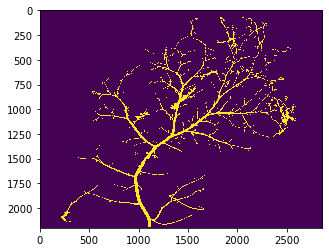

In [8]:
# Import our "image utilities"
from rivgraph import im_utils as iu

# First, let's remove anything that isn't connected to the largest blob of the image
Ib = iu.largest_blobs(Ib, action='keep') # action can also be 'remove' if we want to delete it instead

# Now take a look
plt.imshow(Ib, interpolation='none')

Retaining only the largest "blob" did a good job of removing many of the objects that we didn't want. If we zoom into the mask, we see that the thresholding has resulted in a little "salt and pepper" noise, represented by small holes. Next, we will fill these holes.

Text(0.5, 1.0, 'Holes filled')

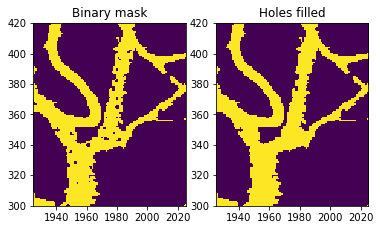

In [17]:
# Fill small holes in the mask. 
Ihf = iu.fill_holes(Ib, maxholesize=100) # maxholesize is # of pixels the largest hole can be; anything smaller will be filled

# Plot for comparison
fig, ax = plt.subplots(1,2)
ax[0].imshow(Ib, interpolation='none')
ax[1].imshow(Ihf, interpolation='none')
xlims = [1925, 2025]
ylims = [300, 420]
ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[0].set_title('Binary mask')
ax[1].set_title('Holes filled')

We also see that the edges of some of the vessels are somewhat sawtoothed (rough, not smooth). We can use morphological erosion and dilation to try to smooth these edges if desired. In many cases, the roughness is not important and we can proceed as-is. The risk of using `erode` and `dilate` is that we can either join objects that should not be joined, or break connectivity where it should not be broken. Let's see what happens.

(300.0, 420.0)

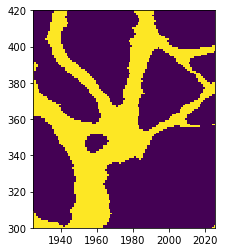

In [25]:
# Dilate first
Ic = iu.dilate(Ihf, n=1, strel='disk') # n is number of times to dilate, strel is the kernel shape (from skimage)
Ic = iu.erode(Ic, n=1, strel='disk')

plt.imshow(Ic, interpolation='none')
plt.xlim(xlims)
plt.ylim(ylims)

The edges are certainly smoother, but we've also created a connection between two arteries that didn't exist before. Smoother boundaries are not critical for extracting the network, since RivGraph traces the skeleton of the objects. So we might choose not to smooth the boundaries at all. 

There are a few other places where the mask is somewhat messy that we might want to clean up. We can touch these areas up by hand:

In [ ]:
# The hand cleaning function allows you to draw a polygon on the mask and fill or erase the pixels within it.
# This function was run multiple times to clean the mask.
Ihc = iu.hand_clean(Ihf, action='erase')